/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/xclim/indices/_multivariate.py:18: UserWarning: xclim.indices.generic has been refactored in xclim v0.21.0 and has moved several functions to 'xclim.indices.stats'. The affected functions are as follows: `fit`, `parametric_quantile`, `fa`, `frequency_analysis`, `get_dist`, `get_lm3_dist`, `_fit_start`, `_lm3_dist_map`. They have been made available here for your convenience. This functionality will change in xclim v0.22.0. Please update your scripts accordingly.
  from .generic import select_resample_op


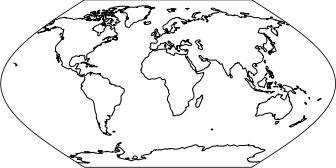

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
import xclim as xc
import os
from memory_profiler import profile

# from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
# import matplotlib.colors as mplcolors
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cmocean as cmo

import matplotlib.gridspec as gridspec
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import Calculation.mask_creation as mc
homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
populationfolder = datafolder + '/gpw-v4/'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"
populationplot = plotfolder + 'Population/'


rcParams_area = {
                'figure.titlesize': 15,
                'axes.titlesize': 'x-large',
                'axes.labelsize': 'x-large',
                'xtick.labelsize': 'large',
                'ytick.labelsize': 'large',
                'hatch.linewidth' : 1,
                'hatch.color' : 'k',
                'figure.facecolor':'w',
                }

plt.rcParams.update(plotfunc.rcParams_area)

**load datasets and choose raster4 as 2020 data**


In [2]:
population = xr.open_dataset(populationfolder + 'gpw_v4_population_density_rev11_2pt5_min.nc').sel(longitude = slice(-14.625 - 1.15/2, 47.25 + 1.15/2), latitude = slice(74.25 + 1.15/2, 31.5 - 1.15/2))
population['density'] = population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].isel(raster = 4)
# population.density.plot.imshow(figsize = (20,20), levels = 10**(np.arange(0,5,0.5)))
population_total = xr.open_dataarray(datafolder + '/population_total.nc')
data= xr.open_dataset(datafolder + '/New2_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')

**Create area dataarraays**

In [3]:
lat_dist = lambda longitude, dist: 111.32*dist + longitude*0
lon_dist = lambda latitude, dist : 111.32*dist * np.cos(np.abs(latitude)/180 * np.pi)

partial_area = lambda lon_diff, lat_low, lat_high : ( - np.cos((lat_high + 90)/ 180 * np.pi) + np.cos((lat_low + 90)/180*np.pi)) * (lon_diff/180) / (4*np.pi)

#calculate data area
area= lambda data : np.meshgrid(lon_dist(data.latitude, data.longitude[1] - data.longitude[0]), lat_dist(data.longitude, data.latitude[0] - data.latitude[1]))
x,y = area(data)
data["area"] = (('latitude','longitude'), np.transpose(x*y))
# calculate population area
y,x = area(population)
pop_area = x*y
population["area"] = (('latitude','longitude'), np.transpose(x*y))

**Calulate total population per gridpoint**

In [4]:
population['total'] = population.area * population.density
print(population.total.sum().values)
# population.total.plot.imshow(figsize = (20,20), levels = 10**(np.arange(0,5,0.5)))

1126802630.1608484


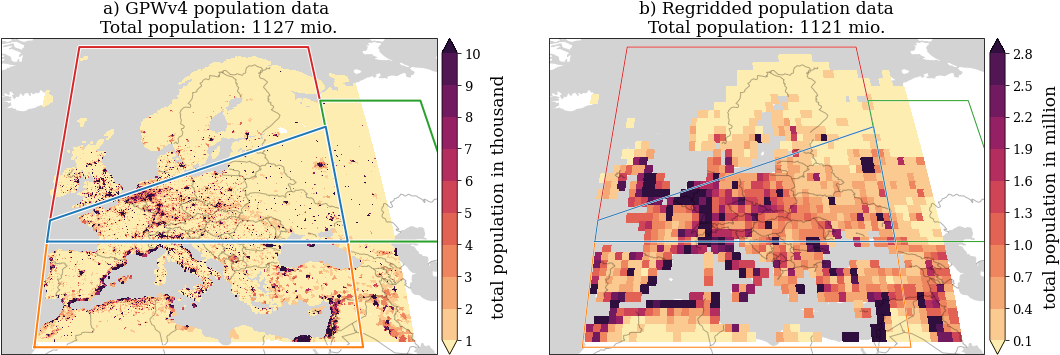

In [14]:
lon_slice = slice(-15, 55)
lat_slice = slice(75, 30)
bound = [lon_slice.start +0.5, lon_slice.stop -0.5, lat_slice.stop +1.5, lat_slice.start -0.5]
bound = np.round(bound, decimals = 0)
projection = ccrs.EckertV(central_longitude=12.5)
plot_dict = dict(set_extent = True)

# print(plot_data)

fig = plt.figure(figsize = (18,21))
gs = gridspec.GridSpec(1,2)

# original gpw-v4 data
plot_data = population.total.where(population.total > 0).sel(longitude = lon_slice, latitude = lat_slice)
ax0 = fig.add_subplot(gs[0,0], projection = projection)
ax0.set_title('a) GPWv4 population data \nTotal population: {:.0f} mio.'.format(plot_data.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = plot_data *1e-3, ax = ax0, cmap = "cmo.matter", levels = np.arange(1,10.1,1), colorbar_kwargs = dict(label = "total population in thousand"), **plot_dict)

# best approx
moved_pop = (data.population_total).sel(longitude = lon_slice, latitude = lat_slice)
ax1 = fig.add_subplot(gs[0,1], projection = projection)
ax1.set_title('b) Regridded population data\nTotal population: {:.0f} mio.'.format(moved_pop.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = moved_pop *1e-6, ax = ax1, cmap = "cmo.matter", levels = np.arange(0.1,3,0.3), colorbar_kwargs = dict(label = "total population in million"), **plot_dict)


In [11]:
fig.savefig(populationplot + "population_regrid.png")

**calculate regridded population without moving people from ocean to land**

In [8]:
# calculate data_population:
data['population_total_old'] = (('latitude', 'longitude'),data.t2m.isel(time = 0) * 0)

for lat_idx in range(len(data.latitude)) :
    for lon_idx in range(len(data.longitude)) :
        lon_value = data.longitude[lon_idx].values
        lat_value = data.latitude[lat_idx].values
        lon_slice = slice(lon_value - 1.124/2, lon_value + 1.125/2)
        lat_slice = slice(lat_value + 1.124/2, lat_value - 1.125/2)
        data['population_total_old'][lat_idx, lon_idx] = (population.total.sel(latitude = lat_slice, longitude = lon_slice)).sum()

data['population_total_old'] = data.population_total_old.where(data.population_total_old > 0, other = np.nan)
print(population.total.sum())
print(data.population_total_old.sum())

<xarray.DataArray 'total' ()>
array(1.12680263e+09)
<xarray.DataArray 'population_total_old' ()>
array(1.1268024e+09, dtype=float32)


**Problem with areas along shore which aren't part of my calculation**

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


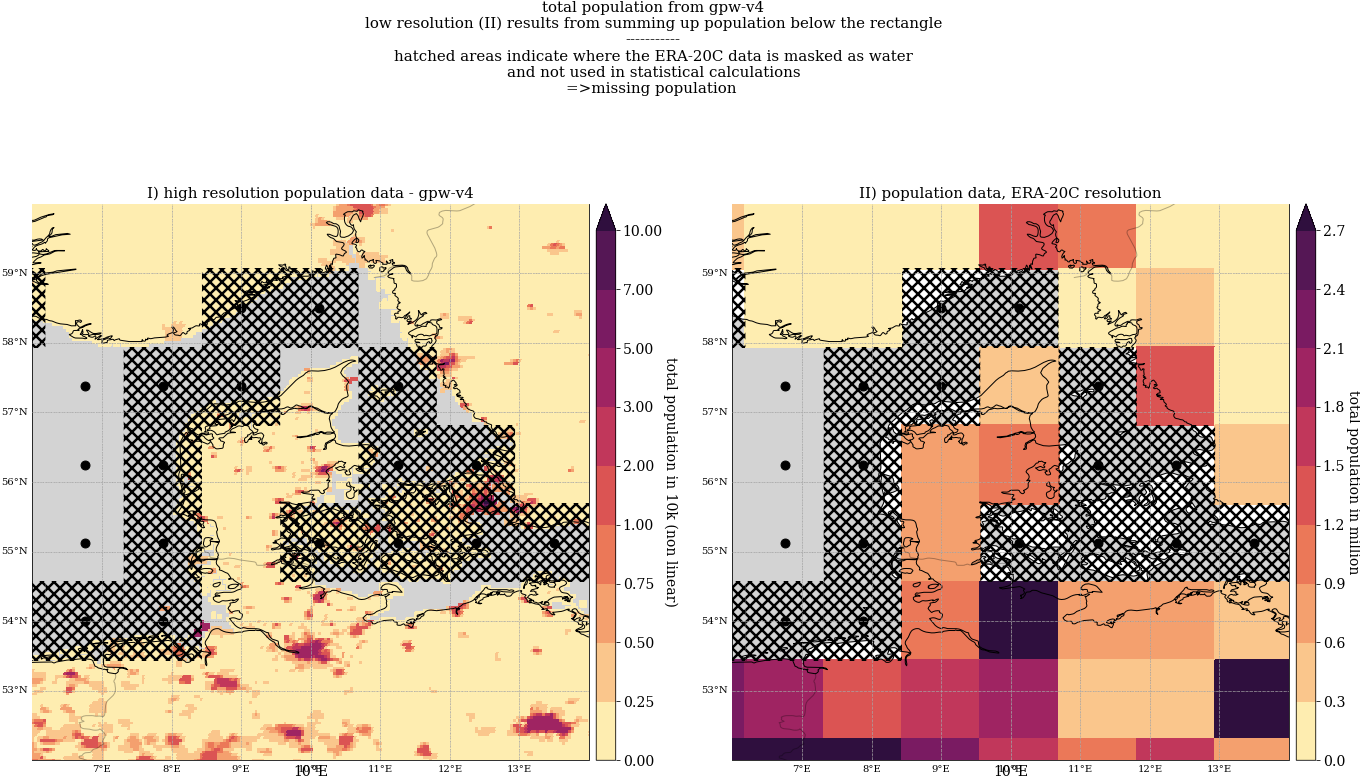

In [9]:
lon_slice = slice(5, 14.5)
lat_slice = slice(60, 50)
bound = [lon_slice.start +0.5, lon_slice.stop -0.5, lat_slice.stop +1.5, lat_slice.start -0.5]
bound = np.round(bound, decimals = 0)
projection = ccrs.PlateCarree(central_longitude = (lon_slice.stop - lon_slice.start)/2)
plot_dict = dict(set_extent = False)

fig = plt.figure(figsize = (23,14))
gs = gridspec.GridSpec(1,2)


ax0 = fig.add_subplot(gs[0,0], projection = projection)
pop_plot = population.total.sel(longitude = lon_slice, latitude = lat_slice)
pm, ct = plotfunc.area_plot(data = pop_plot/10000, ax = ax0, cmap = "cmo.matter", levels = [0,0.25,0.5,0.75,1,2,3,5,7,10], colorbar_kwargs = dict(label = "total population in 10k (non linear)"), **plot_dict)
# with plt.rc_context({'hatch.color' : 'k'}):
#     plt.pcolor(pop_plot.longitude, pop_plot.latitude, pop_plot.where(mc.mask_land(pop_plot)), shading='auto', alpha = 0. ,hatch = "\\\\\\")
plot_data = data.population_total_old.sel(longitude = lon_slice, latitude = lat_slice)
# with plt.rc_context({'hatch.color' : 'tab:red'}):
#     ax0.pcolor(pop_plot.longitude, pop_plot.latitude, pop_plot.where(~mc.mask_land(pop_plot)), shading='nearest', alpha = 0. ,hatch = "\\\\\\")
with plt.rc_context({'hatch.color' : 'k'}):
    x,y = np.meshgrid(plot_data.longitude, plot_data.latitude) 

    ax0.pcolor(plot_data.longitude, plot_data.latitude, plot_data.where(~mc.mask_land(plot_data)), shading='auto', alpha = 0. ,hatch = "//\\\\", zorder = 10, transform = ccrs.PlateCarree())
    ax0.scatter(x[~mc.mask_land(plot_data).values],y[~mc.mask_land(plot_data).values], s = 80,marker = "o", color = 'k', zorder = 10, transform = ccrs.PlateCarree())

# plotfunc.add_cbar(fig, ax0, pm)

# plot low resolution data
ax1 = fig.add_subplot(gs[0,1], projection = projection)
pop_plot = population.total.sel(longitude = lon_slice, latitude = lat_slice)
# ax.pcolormesh(pop_plot.longitude, pop_plot.latitude, pop_plot, cmap = "cmo.matter")

plot_data = data.population_total_old.sel(longitude = lon_slice, latitude = lat_slice)
pm, ct = plotfunc.area_plot(data = plot_data.where(mc.mask_land(plot_data)) *1e-6, ax = ax1, cmap = "cmo.matter", levels = np.arange(0,3,0.3), colorbar_kwargs = dict(label = "total population in million"), **plot_dict)


with plt.rc_context({'hatch.color' : 'k'}):
    x,y = np.meshgrid(plot_data.longitude, plot_data.latitude) 

    ax1.pcolor(plot_data.longitude, plot_data.latitude, plot_data.where(~mc.mask_land(plot_data)), shading='auto', alpha = 0. ,hatch = "//\\\\", zorder = 10, transform = ccrs.PlateCarree())
    ax1.scatter(x[~mc.mask_land(plot_data).values],y[~mc.mask_land(plot_data).values], s = 80,marker = "o", color = 'k', zorder = 10, transform = ccrs.PlateCarree())

# with plt.rc_context({'hatch.color' : 'tab:red'}):
#     ax1.pcolor(pop_plot.longitude, pop_plot.latitude, pop_plot.where(~mc.mask_land(pop_plot)), shading='nearest', alpha = 0. ,hatch = "\\\\\\", zorder = 10, transform = ccrs.PlateCarree())
# plotfunc.add_cbar(fig, ax1, pm)

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
for axs in [ax0,ax1]:

    gl = axs.gridlines(zorder = 15, alpha = 0.7, linestyle = '--')
    gl.xlocator = mticker.FixedLocator(np.arange(bound[0],bound[1],1))
    gl.ylocator = mticker.FixedLocator(np.arange(bound[2],bound[3],1))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    axs.set_extent(bound)
    
fig.suptitle('total population from gpw-v4\nlow resolution (II) results from summing up population below the rectangle\n-----------\nhatched areas indicate where the ERA-20C data is masked as water\nand not used in statistical calculations\n=>missing population ', y=0.98)
ax0.set_title('I) high resolution population data - gpw-v4')
ax1.set_title('II) population data, ERA-20C resolution')

fig.savefig("population_calulation_problem.png", facecolor='w')

In [7]:
# calculate data_population with nearest option of surrounding places.

def calc_distance(lat1, lat2, lon1, lon2):
    '''
    NOTE: works with radians
    '''

    deg_to_rad = lambda x : x/180 *np.pi
    lat1 = deg_to_rad(lat1)
    lat2 = deg_to_rad(lat2)
    lon1 = deg_to_rad(lon1)
    lon2 = deg_to_rad(lon2)
    delta_lat = lat1 - lat2
    delta_lon = lon1 - lon2
    mean_lat = (lat1 + lat2)/2
    
    return (6371.009)*np.sqrt(delta_lat**2 + (np.cos(mean_lat)*delta_lon)**2)
def calc_distance_EW(lat1, lat2, lon1, lon2):
    deg_to_rad = lambda x : x/180 *np.pi
    lat1 = deg_to_rad(lat1)
    lat2 = deg_to_rad(lat2)
    lon1 = deg_to_rad(lon1)
    lon2 = deg_to_rad(lon2)
#     return np.arccos(sin(lat1)*sin(lat2)+cos(lat1)*cos(lat2)*cos(lon1-lon2))
    return 6371.009*2*np.arcsin(np.sqrt((np.sin((lat1-lat2)/2))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)/2))**2))
def calc_distance_FCC(lat1, lat2, lon1, lon2) :
    
    deg_to_rad = lambda x : x/180 *np.pi
    
    delta_lat = lat1 - lat2
    delta_lon = lon1 - lon2
    mean_lat = (deg_to_rad(lat1) + deg_to_rad(lat2))/2
    
#     return (6371.009)*np.sqrt(delta_lat**2 + (np.cos(mean_lat)*delta_lon)**2)
    K1 = 111.13209 - 0.56605 * np.cos(2* mean_lat) + 0.00120 * np.cos(4 * mean_lat)
    K2 = 111.41513 * np.cos(mean_lat) - 0.09455 * np.cos(3*mean_lat) + 0.00012 * np.cos(5 * mean_lat)
    
    return np.sqrt((K1*delta_lat)**2 + (K2*delta_lon)**2)


print(calc_distance(48.8588, 52.5200 , 2.3499, 13.4050))
print(calc_distance_EW(48.8588, 52.5200 , 2.3499, 13.4050))
print(calc_distance_FCC(48.8588, 52.5200 , 2.3499, 13.4050))

878.7634227958636
877.478588910099
881.0285291526485


In [8]:
def get_land_gpw(data, population, percentage= 2/3):
    mask = (data.area * 0).astype(bool)
    pop_area = population.area.where((population.total > 0))
    for lat_idx in range(len(data.latitude)) :
        for lon_idx in range(len(data.longitude)) :
            lon_value = data.longitude[lon_idx].values
            lat_value = data.latitude[lat_idx].values
            lon_slice = slice(lon_value - 1.124/2, lon_value + 1.125/2)
            lat_slice = slice(lat_value + 1.124/2, lat_value - 1.125/2)

            if pop_area.sel(latitude = lat_slice, longitude = lon_slice).sum() >= data.area[lat_idx,lon_idx] * percentage :
                mask[lat_idx, lon_idx] = True
            
    return mask


    
def regridd_with_nearest(data, population, mask ):
    lon_array, lat_array = np.meshgrid(data.longitude, data.latitude)
    lat_array[~mask.values] = np.nan
    lon_array[~mask.values] = np.nan
    lat_array = xr.DataArray(lat_array, dims= dict(latitude = data.latitude, longitude = data.longitude))
    lon_array = xr.DataArray(lon_array, dims= dict(latitude = data.latitude, longitude = data.longitude))

    # create index array
    lat_index_array = np.repeat(np.arange(data.latitude.size), data.longitude.size).reshape(lat_array.shape)
    lon_index_array = np.repeat(np.arange(data.longitude.size), data.latitude.size).reshape(lat_array.transpose().shape).transpose()
    lat_index_array = xr.DataArray(lat_index_array, dims= dict(latitude = data.latitude, longitude = data.longitude))
    lon_index_array = xr.DataArray(lon_index_array, dims= dict(latitude = data.latitude, longitude = data.longitude))

    
    
    count = 0
    count1 = 0
    count2 = 0
    # calculate data_population:
    total_new = data.t2m.isel(time = 0) * 0

    for lat_idx in range(len(total_new.latitude)) :
#     for lat_idx in np.arange(18,20) :
        lat_value = total_new.latitude[lat_idx].values
        lat_slice = slice(lat_value + 1.124/2, lat_value - 1.125/2)    
    
#         for lon_idx in np.arange(22,23) :
        for lon_idx in range(len(total_new.longitude)) :
                lon_value = total_new.longitude[lon_idx].values
                lon_slice = slice(lon_value - 1.124/2, lon_value + 1.125/2)
                pop = population.total.sel(latitude = lat_slice, longitude = lon_slice)
#             if mask[lat_idx,lon_idx]:
#                 total_new[lat_idx, lon_idx] = total_new[lat_idx, lon_idx] + pop.sum().values
#                 count += 1
#             else :
                closest = pop * 0
                lon_near = lon_array[lat_idx-1:lat_idx+2,lon_idx-1 : lon_idx+2]
                lat_near = lat_array[lat_idx-1:lat_idx+2,lon_idx-1 : lon_idx+2]
                lon_index_near = lon_index_array[lat_idx-1:lat_idx+2,lon_idx-1 : lon_idx+2]
                lat_index_near = lat_index_array[lat_idx-1:lat_idx+2,lon_idx-1 : lon_idx+2]
                
                neighbours = np.stack((lat_near,lon_near),axis=2)
                neighbours = neighbours.reshape(int(np.size(neighbours)/2), 2)
                neighbours_index = np.stack((lat_index_near,lon_index_near),axis=2)
                neighbours_index = neighbours_index.reshape(int(np.size(neighbours_index)/2), 2)
                
                if np.nansum(neighbours) > 0:
                    min_distance = pop * 0 + max_distance
                    closest_lat = pop.values * np.nan
                    closest_lon = pop.values * np.nan
                    
                    for neighour, neighour_index in zip(neighbours, neighbours_index):
                        if np.nansum(neighour) > 0:
                            
#                             print(neighour, neighour_index)
                            distance = (calc_distance(data.latitude[neighour_index[0]],pop.latitude,data.longitude[neighour_index[1]],pop.longitude))
                            min_mask = min_distance > distance
                            min_distance = distance.where(min_mask, other = 0) + min_distance.where(~min_mask,other = 0)
                            closest_lat[min_mask.values] = neighour_index[0]
                            closest_lon[min_mask.values] = neighour_index[1]
                    #after creating the neighbour index aray use it to add to each 
                    for neighour, neighour_index in zip(neighbours, neighbours_index):
                        destination_lat = neighour_index[0]
                        destination_lon = neighour_index[1]
                        
                        total_new[destination_lat, destination_lon] = total_new[destination_lat, destination_lon] + pop.where((closest_lat == destination_lat) & (closest_lon == destination_lon)).sum(min_count = 0).values
    if total_new.where(total_new < 0).sum() != 0:
        print('negative values of population')
    
    total_new = total_new.where(total_new > 0)
    
    return total_new

st = time.time()
max_distance = 100
mask_area_partial = get_land_gpw(data, population, percentage = 1/3)
mask_area_partial = mc.mask_land(data.t2m.isel(time = 0)) + mask_area_partial
mask_land = mask_area_partial.astype(bool)
population_total = regridd_with_nearest(data, population, mask_area_partial)

print(time.time() - st)

76.20800042152405


/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


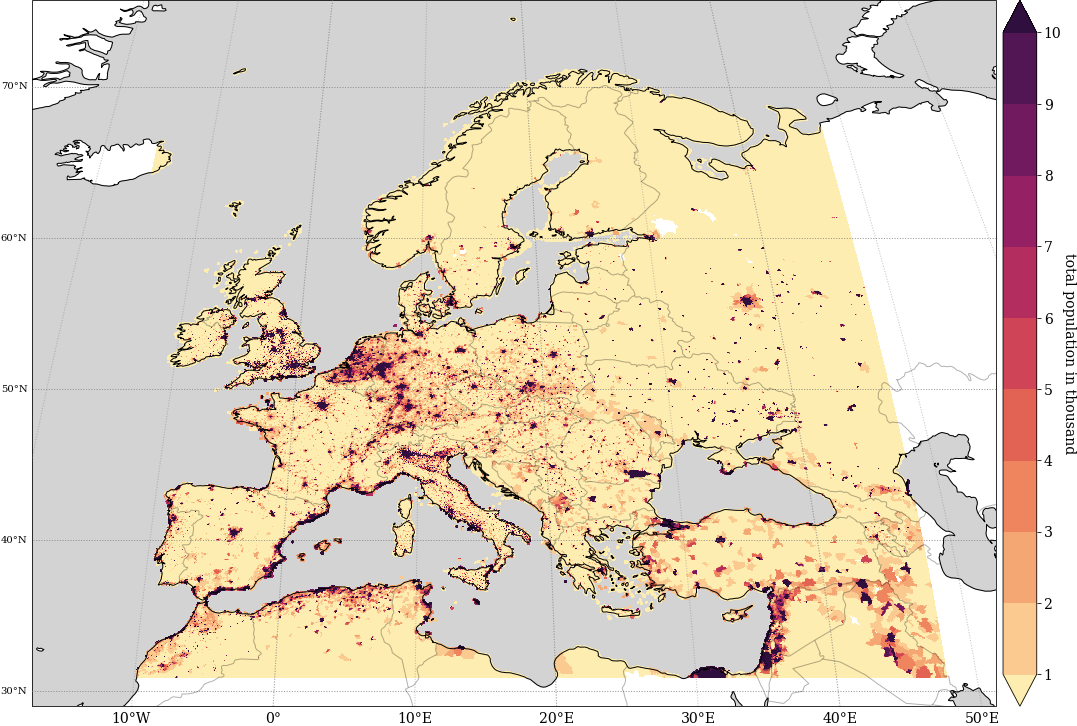

In [19]:
fig = plt.figure(figsize = (18,21))
plot_data = population.total.where(population.total > 0).sel(longitude = lon_slice, latitude = lat_slice)
ax0 = fig.add_subplot(111, projection = projection)
pm, ct = plotfunc.area_plot(data = plot_data *1e-3, ax = ax0, cmap = "cmo.matter", levels = np.arange(1,10.1,1), colorbar_kwargs = dict(label = "total population in thousand"), **plot_dict)

**SAVE DATA WITH POPULATION**

In [23]:
try : data = data.drop('population_total_old')
except : pass
data['population_total'] = population_total
data.population_total.attrs = dict(long_name = 'total population per gridpoint', units= 'people')
data.area.attrs = dict(long_name = 'area per gridpoint in km^2', units = 'km^2')
data['mask_land'] = mask_area_partial.astype(bool)
data.mask_land.attrs = dict(long_name = 'land/ocean mask (1/0)', origin='at least 1/3 of surrounding surface must be land to be masked as land (based on python regionmask combined with gpw-v4 population data as placed where land is)')
data.to_netcdf(datafolder + '/New_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')
population_total.to_netcdf(datafolder + '/population_total.nc')

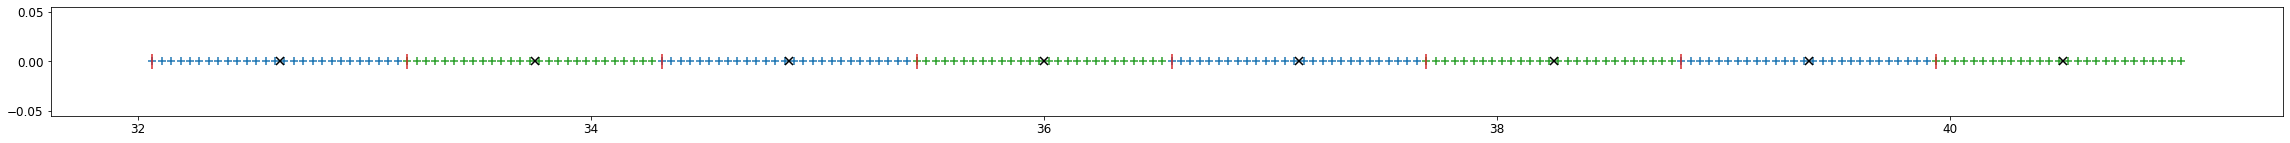

In [49]:
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgewidth'] =  1.5

plt.figure(figsize = (40,2))
for idx in np.arange(30,38,1) :

    data_dim = data.latitude[idx:idx + 1]
    middle = (data.latitude[idx] + data.latitude[idx +1])/2
    pop = population.latitude.sel(latitude = slice(data_dim.values[0] + 1.124/2, data_dim.values[0] - 1.125/2))
    
    if idx%2 != 0:
        plt.plot(pop, pop*0, marker = '+', linestyle = '', color = "tab:blue")
    else :
        plt.plot(pop, pop*0, marker = '+', linestyle = '', color = "tab:green")
    plt.plot(data_dim, data_dim*0, marker = 'x', color = "k", linestyle = '')
    plt.plot(middle, middle*0, marker = '|', markersize = 15,  color = "tab:red", linestyle = '')
    

In [32]:
population_regrid.where(mc.mask_land(population_regrid)).sum().values

array(8.36081e+08, dtype=float32)

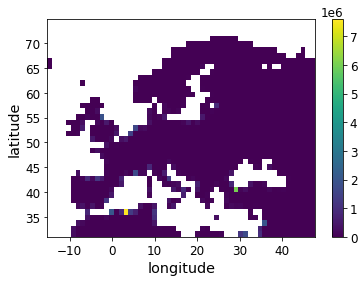

In [12]:
(data.population_total - data.population_total_old).plot.imshow()

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


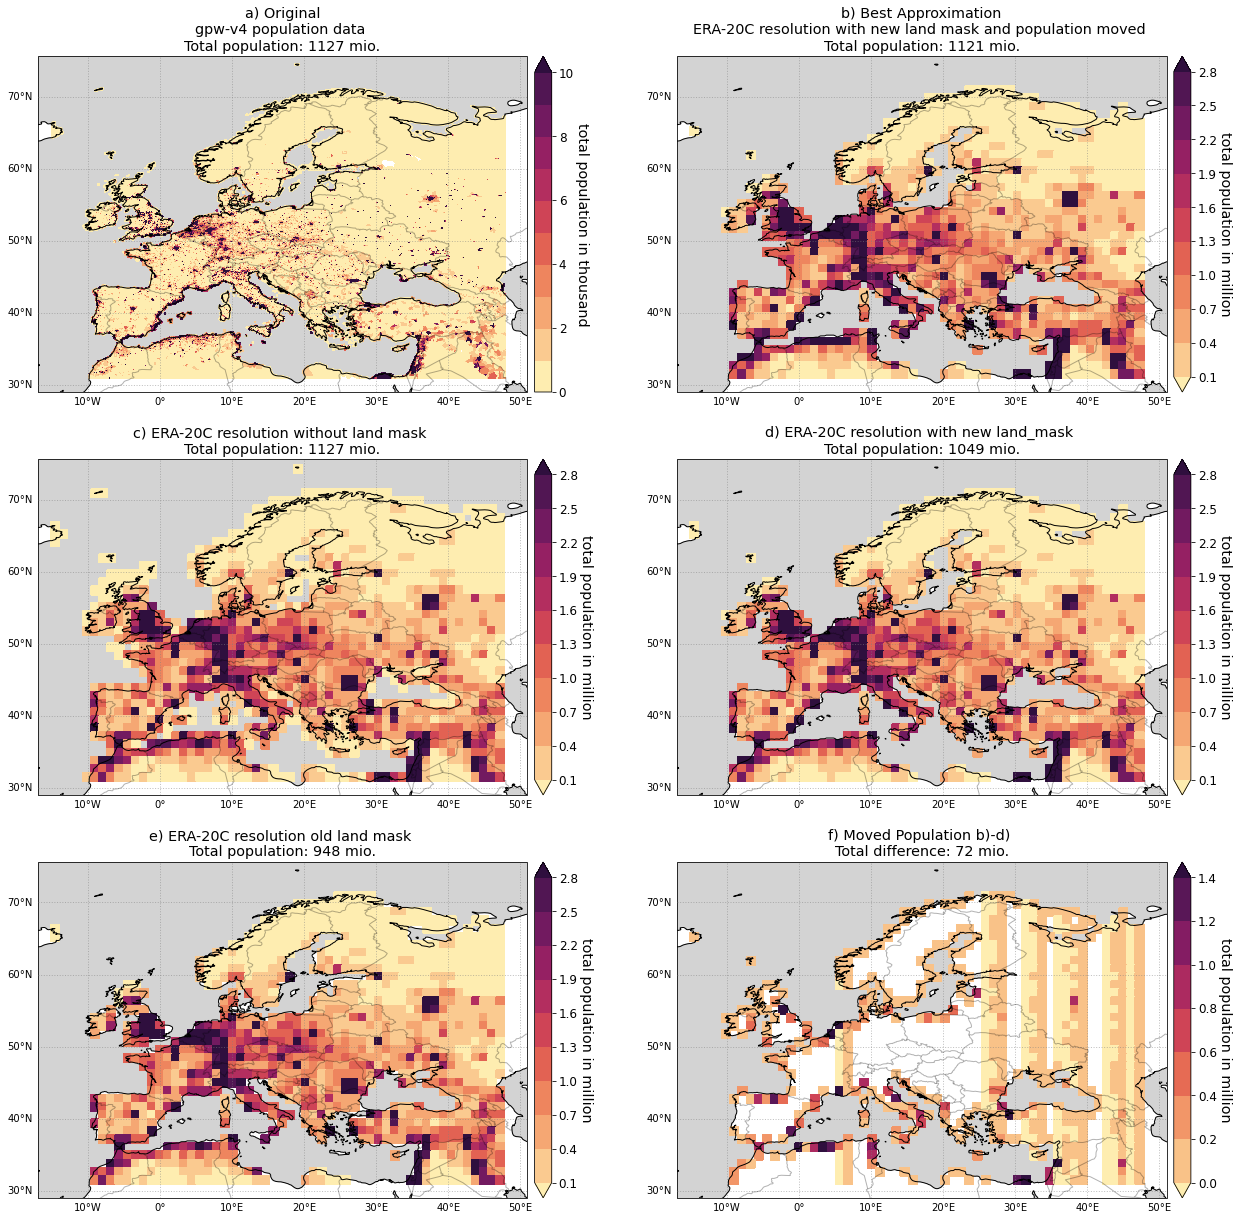

In [12]:
lon_slice = slice(-15, 55)
lat_slice = slice(75, 30)
bound = [lon_slice.start +0.5, lon_slice.stop -0.5, lat_slice.stop +1.5, lat_slice.start -0.5]
bound = np.round(bound, decimals = 0)
projection = ccrs.PlateCarree(central_longitude = (lon_slice.stop - lon_slice.start)/2)
plot_dict = dict(set_extent = True)

# print(plot_data)

fig = plt.figure(figsize = (21,21))
gs = gridspec.GridSpec(3,2)

# original gpw-v4 data
plot_data = population.total.where(population.total > 0).sel(longitude = lon_slice, latitude = lat_slice)
ax0 = fig.add_subplot(gs[0,0], projection = projection)
ax0.set_title('a) Original\ngpw-v4 population data \nTotal population: {:.0f} mio.'.format(plot_data.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = plot_data *1e-3, ax = ax0, cmap = "cmo.matter", levels = np.arange(0,10.1,1), colorbar_kwargs = dict(label = "total population in thousand"), **plot_dict)

# best approx
moved_pop = (data.population_total).sel(longitude = lon_slice, latitude = lat_slice)
ax1 = fig.add_subplot(gs[0,1], projection = projection)
ax1.set_title('b) Best Approximation\nERA-20C resolution with new land mask and population moved \nTotal population: {:.0f} mio.'.format(moved_pop.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = moved_pop *1e-6, ax = ax1, cmap = "cmo.matter", levels = np.arange(0.1,3,0.3), colorbar_kwargs = dict(label = "total population in million"), **plot_dict)

# ERA-20C resolution NO MASK
plot_data = data.population_total_old.sel(longitude = lon_slice, latitude = lat_slice)
ax2 = fig.add_subplot(gs[1,0], projection = projection)
ax2.set_title('c) ERA-20C resolution without land mask \nTotal population: {:.0f} mio.'.format(plot_data.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = plot_data *1e-6, ax = ax2, cmap = "cmo.matter", levels = np.arange(0.1,3,0.3), colorbar_kwargs = dict(label = "total population in million"), **plot_dict)

# ERA-20C resolution NEW MASK
notmoved_pop = data.population_total_old.where(data.mask_land).sel(longitude = lon_slice, latitude = lat_slice)
ax3 = fig.add_subplot(gs[1,1], projection = projection)
ax3.set_title('d) ERA-20C resolution with new land_mask \nTotal population: {:.0f} mio.'.format(notmoved_pop.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = notmoved_pop *1e-6, ax = ax3, cmap = "cmo.matter", levels = np.arange(0.1,3,0.3), colorbar_kwargs = dict(label = "total population in million"), **plot_dict)

# ERA-20C resolution OLD MASK
plot_data = data.population_total_old.where(mc.mask_land(data.population_total_old)).sel(longitude = lon_slice, latitude = lat_slice)
ax2 = fig.add_subplot(gs[2,0], projection = projection)
ax2.set_title('e) ERA-20C resolution old land mask \nTotal population: {:.0f} mio.'.format(plot_data.sum().values*1e-6))
pm, ct = plotfunc.area_plot(data = plot_data *1e-6, ax = ax2, cmap = "cmo.matter", levels = np.arange(0.1,3,0.3), colorbar_kwargs = dict(label = "total population in million"), **plot_dict)

# DIFFERENCE MOVED POPULATION
plot_data = moved_pop - notmoved_pop
plot_data = plot_data.where(plot_data != 0)
ax3 = fig.add_subplot(gs[2,1], projection = projection)
ax3.set_title('f) Moved Population b)-d) \nTotal difference: {:.0f} mio.'.format(plot_data.sum().round(-6).values*1e-6))
pm, ct = plotfunc.area_plot(data = plot_data *1e-6, ax = ax3, cmap = "cmo.matter", levels = np.arange(0,1.5,0.2), colorbar_kwargs = dict(divergent = False, label = "total population in million"), **plot_dict)
